In [1]:
import os
import glob
import sys
import random
import shutil
import tqdm

# data processing
import tensorflow as tf
import numpy as np
import tetgen
import SimpleITK as sitk
from skimage import measure
from numpy import random
from math import factorial
import numpy as np
from scipy.spatial import distance
from scipy import ndimage
# ploting
import seaborn as sns
import matplotlib
import matplotlib.pylab as plt
%matplotlib inline

import scipy
from scipy.optimize import fmin_cg 
from scipy.stats import chi2
from scipy.stats import wasserstein_distance
import skimage
from tensorflow.keras import layers
import pyvista as polyv
from IPython.display import clear_output
import networkx as nx
sys.path.append('./utils/pyOptFEM/')
from pyOptFEM.FEM3D.assembly import *
from pyOptFEM import *

In [2]:
NU = 0.3                          #(0< NU <0.5)
YOUNG_MODULUS = 1
lame_lambda = YOUNG_MODULUS * NU / ((1 + NU) * (1 - 2 * NU))
shear_modulus = YOUNG_MODULUS / (2 * (1 + NU))
lambda_W = 1e-1

In [3]:
NUM_P = '01'
MIN_PYRAMID_LEVEL = 4
NAME = glob.glob('./patients/'+str(NUM_P)+'*')[-1]
#path_graph = sorted(glob.glob(NAME + '/' + str(MIN_PYRAMID_LEVEL) + '/Output_GRAPH*[!Q]'))[-1]

In [4]:
NAME

'./patients/01'

In [5]:
grid = polyv.read(NAME + '/grid.vtk')
path_graph = sorted(glob.glob(NAME + '/'+'Output_GRAPH*[!Q]'))[-1]
Output_GRAPH = nx.read_gpickle(path_graph)

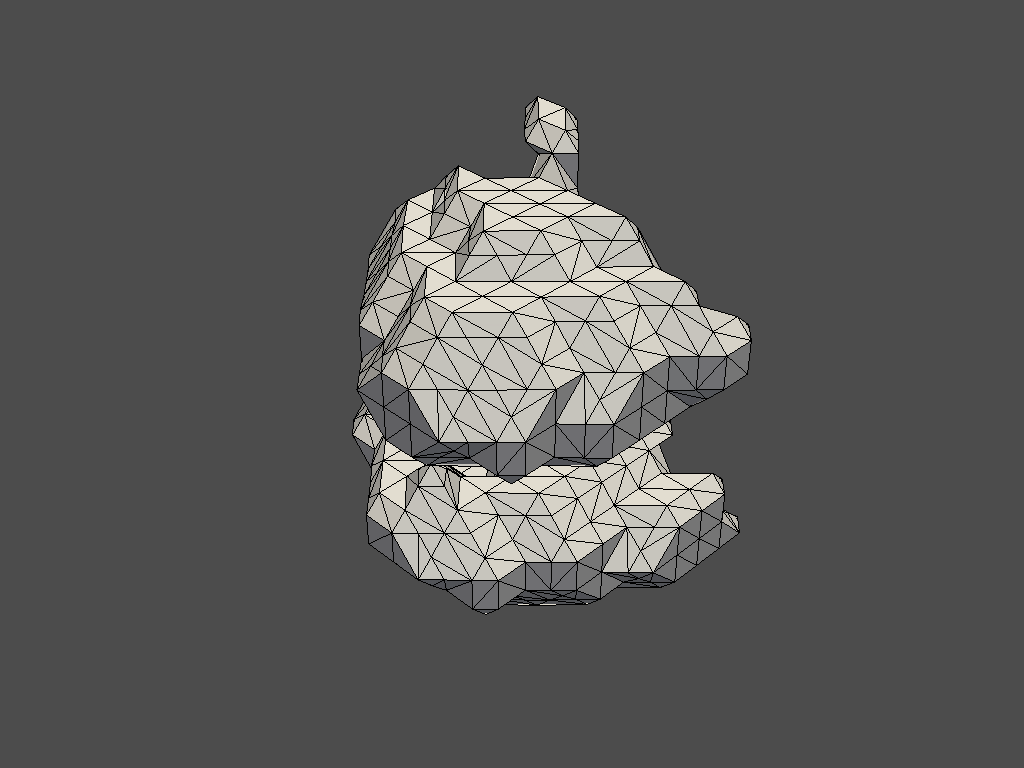

In [6]:
grid.plot(show_edges = True)

# Usefull Func

In [7]:
def pyvistamesh_global_stiffness(grid_mesh, lambda_lame, shear_modulus,  Num = 0):
    """
    :param grid_mesh:
    :param lame_Poisson: shear modulus
    :param shear_modulus:
    :return:
    """

    coors = np.array(grid_mesh.points)  #coordinates Th.q
    n_vertices = grid_mesh.n_points  #Th.nq # n_points

    # mat_ids=np.array(grid_mesh.cells)
    conn = np.reshape(grid_mesh.cells, [-1, 5])[:, 1:]  #Th.me # edges

    #Th.q # coordonnées # int
    n_cells = grid_mesh.n_cells  #Th.nme # num cells (tetrahedrons)
    V = np.array(
        [simplex_volume(vertices=coors[conn][_]) for _ in range(n_cells)])  #Th.volumes # volumes des tetraedres

    return StiffElasAssembling3DP1base(n_vertices, n_cells, coors, conn, V, shear_modulus, lambda_lame, Num)

def calc_D_mats(grid):
    ''''
    '''
    cells = grid.cells.reshape(-1, 5)[:, 1:]
    ls_Hinv=[]
    for i in range(cells.shape[0]):
        cell = cells[i]
        Q = grid.points[cell]
        v=simplex_volume(vertices=Q)
        ls_Hinv.append(ComputeGradient(Q).T/(6*v))
    return np.stack(ls_Hinv,axis=0)




def simplex_volume(*, vertices=None, sides=None) -> float:
    """
    Return the volume of the simplex with given vertices or sides.

    If vertices are given they must be in a NumPy array with shape (N+1, N):
    the position vectors of the N+1 vertices in N dimensions. If the sides
    are given, they must be the compressed pairwise distance matrix as
    returned from scipy.spatial.distance.pdist.

    Raises a ValueError if the vertices do not form a simplex (for example,
    because they are coplanar, colinear or coincident).

    Warning: this algorithm has not been tested for numerical stability.
    """

    # Implements http://mathworld.wolfram.com/Cayley-MengerDeterminant.html

    if (vertices is None) == (sides is None):
        raise ValueError("Exactly one of vertices and sides must be given")

    # β_ij = |v_i - v_k|²
    if sides is None:
        vertices = np.asarray(vertices, dtype=float)
        sq_dists = distance.pdist(vertices, metric='sqeuclidean')

    else:
        sides = np.asarray(sides, dtype=float)
        if not distance.is_valid_y(sides):
            raise ValueError("Invalid number or type of side lengths")

        sq_dists = sides ** 2

    # Add border while compressed
    num_verts = distance.num_obs_y(sq_dists)
    bordered = np.concatenate((np.ones(num_verts), sq_dists))

    # Make matrix and find volume
    sq_dists_mat = distance.squareform(bordered)

    coeff = - (-2) ** (num_verts - 1) * factorial(num_verts - 1) ** 2
    vol_square = np.linalg.det(sq_dists_mat) / coeff

    if vol_square <= 0:
        raise ValueError('Provided vertices do not form a tetrahedron')

    return np.sqrt(vol_square)


# Other variables

In [8]:
n_vertices = grid.points.shape[0]
n_tetrahedron = grid.cells.shape[0]
t_n = np.array([nx.get_node_attributes(Output_GRAPH, 'accumulated_translation')[_]
                  for _ in range(n_vertices)])  ## translation parameters
Pns = np.array([nx.get_node_attributes(Output_GRAPH, 'Pn')[_]
                for _ in range(n_vertices)])   ## Point P

t_n_vec = (t_n).reshape([-1])                     ## One dimensional vector with x,y,z one after another


In [9]:
t_n_vec

array([ 29.33157263,  15.26091874,   7.021381  , ..., -11.98054776,
         6.67573772,   0.22301136])

In [10]:
sigm_t = 1
sigm_A = 1

# Stiffness Matrix M

In [11]:
S_sparse = pyvistamesh_global_stiffness(grid, lame_lambda, shear_modulus)
Km = scipy.sparse.csr_matrix.todense(S_sparse)
#Dmat = calc_D_mats(grid)  # shape N_tetrahedron x 4 x 3


# Stiffness Matrix T

In [14]:
U = t_n_vec

In [15]:
Kt = np.eye(Km.shape[0]) #/ (2 * sigm_t ** 2)
Rt=t_n_vec #/(sigm_t ** 2)
squared_t = np.sum(t_n_vec**2)/2#+#(2*sigm_t ** 2)
import time
t0 = time.time()

reg_tn = 1/2*np.dot(U.T, Kt).dot(U) - np.dot(U.T,Rt) +squared_t
print(reg_tn)
print(time.time()-t0) 

5.820766091346741e-11
0.05239701271057129


In [16]:
import time
t0 = time.time()
reg_tn = 1/2*np.sum((U-t_n_vec)**2)#/(2*sigm_t ** 2)
print(reg_tn)
print(time.time()-t0)

0.0
0.0005309581756591797


# Stiffness Matrix A

In [17]:
def outer(a):
    '''
    a 1 dimensional vector of size 3
    '''
    outer_a = [[a[0],0,0],
              [0,a[0],0],
              [0,0,a[0]],
              [a[1],0,0],
              [0,a[1],0],
              [0,0,a[1]],
              [a[2],0,0],
              [0,a[2],0],
              [0,0,a[2]]]
    
    return outer_a

def calc_bn(vertex_num,grid):
    tetrahedrons = grid.cells.reshape(-1, 5)[:, 1:]
    Pns = np.array(grid.points)

    # RETURN THE NUMBER OF THE CELLS
    # find the num of tetra
    # if idx_points in cell

    v_i = [num_cell
                 for num_cell, tetra in enumerate(tetrahedrons)
                 if any([idx_cell in [vertex_num] for idx_cell in [*tetra]])]
    c_n = len(v_i)
    
    #print('N TETRA WITH {} : {}'.format(vertex_num,c_n))
 
    ls_Dmat_index_s_i = []
    #ls_Bn_i = []
    list_idx_vertex = np.unique(tetrahedrons[v_i])
    list_idx_vertex_full = tetrahedrons[v_i]

    Bn_mat = np.zeros([len(list_idx_vertex),3])

    for num_tetra,v in enumerate(v_i):            
        ## LOOP WITHIN THETRAHEDRONS
        #print(num_tetra)
        index_vertex_tetra_v = tetrahedrons[v]
        #print(index_vertex_tetra_v)
        P = Pns[index_vertex_tetra_v]
        v = simplex_volume(vertices=P)
        D_mat = ComputeGradient(P).T / (6 * v)
        
        for index_pos_vertex,vertex_idx in enumerate(index_vertex_tetra_v): 
            D_mat_index = D_mat[index_pos_vertex,:] 
            vertex_pos_in_Bn = np.argwhere( vertex_idx == list_idx_vertex)[0][0]
            #print('VERTEX {} POS {}'.format(vertex_idx,vertex_pos_in_Bn))
            #print(D_mat_index)
            Bn_mat[vertex_pos_in_Bn,:] += 1/c_n * D_mat_index
            
            #print(Bn_mat)
            #print(Bn_mat)
    return Bn_mat,list_idx_vertex

def find_neighbors(idx_vertex,grid):
    
    tetrahedrons = grid.cells.reshape(-1, 5)[:, 1:]

    # RETURN THE NUMBER OF THE CELLS
    # find the num of tetra
    # if idx_points in cell

    v_i = [num_cell
                 for num_cell, tetra in enumerate(tetrahedrons)
                 if any([idx_cell in [idx_vertex] for idx_cell in [*tetra]])]
    

    list_idx_vertex = np.unique(tetrahedrons[v_i])
    neighbors = set(list_idx_vertex) - set([idx_vertex])
    return neighbors

In [18]:
num_vertice_test = [10]
idx_tetra_n = [num_cell
             for num_cell, cell in enumerate(np.reshape(grid.cells, [-1, 5])[:, 1:])
             if any([idx_cell in num_vertice_test for idx_cell in [*cell]])]
tetrahedrons = np.reshape(grid.cells,[-1,5])[:,1:]
Pns = np.array([nx.get_node_attributes(Output_GRAPH,'Pn')[idx] for idx in range(n_vertices)])[:,1:-1]
Qns = np.array([nx.get_node_attributes(Output_GRAPH,'Qn')[idx] for idx in range(n_vertices)])[:,1:-1]


In [19]:
nabla_Q=[]
for num_cell in idx_tetra_n:
    tetrahedron = tetrahedrons[num_cell]
    idx_cell = np.argwhere(tetrahedron == num_vertice_test[0])[0][0]
    P = Pns[tetrahedron]
    Q = Qns[tetrahedron]

    v = simplex_volume(vertices=P)
    D_mat = ComputeGradient(P).T / (6 * v)
    nablaQ_n = np.einsum('ij,jk->ik',Q.T,D_mat)
    nabla_Q.append(nablaQ_n)
nabla_Q_or = np.mean(np.array(nabla_Q),axis=0)

In [21]:
nablaQ_n = 0
for idx_vertex in num_vertice_test:
    bn_mat,list_vertex_bn_mat = calc_bn(idx_vertex,grid)
for i in range(bn_mat.shape[0]): 
    print(list_vertex_bn_mat[i])
    nablaQ_n+=np.dot(outer(bn_mat[i,:]),Pns[list_vertex_bn_mat[i]])   ## a confirmer pour .T
    print(Pns[list_vertex_bn_mat[i]])
nabla_Q_vector = nablaQ_n.reshape([3,3]).T
print(nabla_Q_vector)

8
[123.  92. 189.]
9
[113. 103. 189.]
10
[123.  92. 210.]
11
[113. 103. 210.]
12
[123. 103. 220.]
61
[144.  92. 189.]
62
[133. 103. 210.]
[[ 1.00000000e+00 -1.77635684e-15  0.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  2.22044605e-16]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [42]:
## In case stiffness matrix in not organized as [x0,x1,x2] but as 
Ka = np.zeros([3*n_vertices,3*n_vertices])
t0 = time.time()
#row,col,val=[],[],[]
#for i in tqdm.tqdm(range(1)):    ##n_vertices

for i in tqdm.tqdm(range(n_vertices)):    ##n_vertices
    neighbors_i = find_neighbors(i,grid)
    neighbors_i_plus = set(list(neighbors_i) + [i])

    for j in range(i,n_vertices):   ##n_vertices
        neighbors_j= find_neighbors(j,grid)
        neighbors_j_plus = set(list(neighbors_j) + [j])
        common_nodes = neighbors_i_plus.intersection(neighbors_j_plus)
        if len(common_nodes)>0:
            kij = 0
            for common_node in common_nodes:
                bn_mat,list_vertex_bn_mat = calc_bn(common_node,grid)
                idx_i_in_bn_mat = np.argwhere(list_vertex_bn_mat==i)[0][0]
                idx_j_in_bn_mat = np.argwhere(list_vertex_bn_mat==j)[0][0]
                #kij+=np.dot(np.matrix(bn_mat[idx_i_in_bn_mat]).T,np.matrix(bn_mat[idx_j_in_bn_mat]))
                kij = np.dot(bn_mat[idx_i_in_bn_mat],bn_mat[idx_j_in_bn_mat]) #/ (sigm_A**2)
                Ka[3*i:3*i+3,3*j:3*j+3] += kij*np.eye(3)
Ka += ((Ka)*(1-np.eye(Ka.shape[0]))).T

100%|██████████| 42/42 [00:04<00:00, 18.30it/s]


# Stack Save and visualize

In [11]:
Stiffs_staked = np.stack([np.array(Km),np.array(Kt),np.array(Ka)])

NameError: name 'Km' is not defined

In [12]:
np.save('/Users/paulbd/Documents/Projects/lung_registration/patients/'+NUM_P+"/stiffs_stacked",Stiffs_staked)

NameError: name 'Stiffs_staked' is not defined

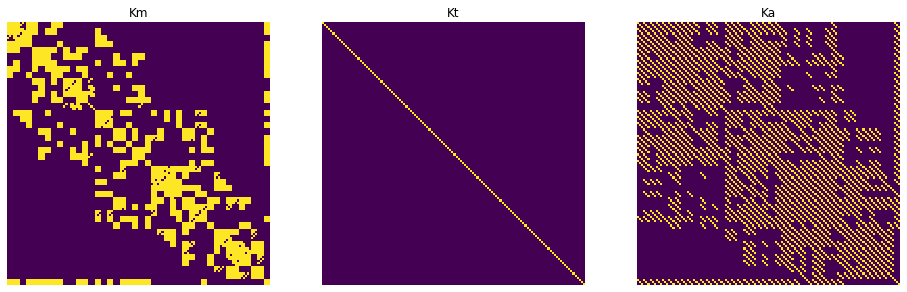

In [43]:
fig,ax=plt.subplots(1,3,figsize=(16,7))
ax[0].imshow(Km!=0)
ax[1].imshow(Kt!=0)
ax[2].imshow(Ka!=0)
ax[0].set_axis_off()
ax[0].set_title('Km')
ax[1].set_axis_off()
ax[1].set_title('Kt')
ax[2].set_axis_off()
ax[2].set_title('Ka')

plt.show()

# Q-step

# Test Conditions 

In [22]:
def estimate_mean_variance_as_paper(Graph,grid): 
    n_vertices = Graph.number_of_nodes()
    #tn = np.stack(
    #    [nx.get_node_attributes(Graph, 'translation_from_Pn')[key] for key in range(n_vertices)])
    Qns = np.array(np.stack(
        [nx.get_node_attributes(Graph, 'Qn')[key][1:-1] for key in range(n_vertices)]))
    Pns = np.array(np.stack(
        [nx.get_node_attributes(Graph, 'Pn')[key][1:-1] for key in range(n_vertices)]))
    
    tn = np.array(Qns - Pns)
    n_vertices = grid.number_of_points

    std_tn = tn.ravel().std()


    t = np.mean(tn, axis=0)
    t_cov = np.cov(tn, rowvar=False)

    mahalanobis_distance = (np.diag(
        (np.dot((np.dot((tn - t), np.linalg.inv(t_cov))), (tn - t).T)))) ** 0.5
    z = chi2.cdf(mahalanobis_distance, 3)
    
    An = np.stack(
        [nx.get_node_attributes(Graph, 'affines_or')[key][:, :-1] for key in range(n_vertices)])
    #An = np.array([np.eye(3) for _ in range(n_vertices) ])

    A = np.mean(An,axis = 0)
    std_t = np.diag(t_cov)**0.5

    ls_nablaQ = []
    Ra_new = np.zeros([tn.shape[0],3])
    
    for idx_vertex_RA in range(n_vertices):
        An_n = An[idx_vertex_RA]
        Bn_idx_n,ls_vertex_Bn_idx = calc_bn(idx_vertex_RA,grid)
        #epsilon_A.append((An_n-np.eye(3))**2/(2*(std_A**2)))
        nablaQ_n = 0     
        #Ra_i = 0
        #ls_Rai = []
        for idx_enum_i, _ in enumerate(Bn_idx_n):
            Bn_i = Bn_idx_n[idx_enum_i,...]
            Ra_new[ls_vertex_Bn_idx[idx_enum_i],:]+=Bn_i.dot((An_n-np.eye(3)))
            nablaQ_n+=np.matrix(outer(Bn_i)).dot(Qn_i_test[ls_vertex_Bn_idx[idx_enum_i],...])
        ls_nablaQ.append(nablaQ_n.reshape([3,3]).T)
        

        
    Ra = np.array(Ra_new).reshape([-1])
    Rt = tn.reshape([-1])
    #print(Rt)
        
    nablaQ = np.array(ls_nablaQ)
    diff = An-nablaQ
    std_A = np.std(diff.ravel())
    std_t = np.array([std_tn]*3)

    return t,A,std_t,std_tn,std_A,Rt,Ra,z



def Q_step(Graph,grid,K,lambda_Km,divide_variance=False):
    '''
    Graph : A graph
    Grid : a grid
    K : the np array of the three stiffness matrices in that order Km,Kt,ka
    lambda_Km : 
    '''
    # estimate variance and mean
    new_graph = Graph.copy()
    t,A,std_t,std_tn,std_A,Rt,Ra,z = estimate_mean_variance_as_paper(new_graph,grid)

    #print(std_A)
    # 
    stiff = np.copy(K)
    Km_Q = stiff[0,...]
    Kt_Q = stiff[1,...]
    Ka_Q = stiff[2,...]
    
    print(std_tn)
    print(std_A)
    std_A *= 10

    
    
    if divide_variance:
        Kt_Q/=(std_tn**2)
        Ka_Q/=(std_A**2)
        Rt/=(std_tn**2)
        Ra/=(std_A**2)        

    matrix_assembly = lambda_Km*Km_Q + Kt_Q + Kq_Q
    #matrix_assembly = lambda_Km*Km + Kt/(std_tn**2) + (Ka/std_A**2)
    x = np.dot(np.linalg.inv(np.matrix(matrix_assembly)),(Rt+Ra))
    x_reshaped = np.array(x.reshape([-1,3]))
    
    
    for idx_vertex in range(new_graph.number_of_nodes()):
        Pn_idx = np.copy(nx.get_node_attributes(new_graph,'Pn')[idx_vertex])
        new_Qn = Pn_idx
        #x_inv = - x_reshaped[idx_vertex,:]
        new_Qn[1:-1] += x_reshaped[idx_vertex,:]
        new_graph.add_node(idx_vertex, Qn = new_Qn, accumulated_translation= -x_reshaped[idx_vertex,:])
    return new_graph,x_reshaped

In [23]:
grid = polyv.read('./patients/'+NUM_P+'/'+'/grid.vtk')
Output_GRAPH = nx.read_gpickle('./patients/'+NUM_P+'/Output_GRAPH0')
K = np.load('./patients/'+NUM_P+'/'+'/stiffs_stacked.npy')
n_vertices = Output_GRAPH.number_of_nodes()

In [24]:
#t_i = np.stack(
#        [nx.get_node_attributes(Output_GRAPH, 'translation_from_Pn')[key] for key in range(Output_GRAPH.number_of_nodes())])
Qn_i = np.stack(
        [nx.get_node_attributes(Output_GRAPH, 'Qn')[key] for key in range(Output_GRAPH.number_of_nodes())])
Pn_i = np.stack(
        [nx.get_node_attributes(Output_GRAPH, 'Pn')[key] for key in range(Output_GRAPH.number_of_nodes())])

t_n = ( Qn_i - Pn_i)[:,1:-1]

In [25]:
Km = np.copy(K[0,...])
Kt = np.copy(K[1,...])
Ka = np.copy(K[2,...])


## CHECK SQUARED ERRORS

## For t

In [26]:
U = t_n.reshape([-1])
#U = np.array([[1,2,3]*n_vertices]).reshape([-1])

In [27]:
tn_vec = t_n.reshape([-1])
Rt = t_n.reshape([-1])


In [28]:
#t_rep = np.array([t]*t_i.shape[0])
#U = t_rep.reshape([-1])

In [29]:
epsilon_t = np.sum(t_n**2)/2#+#(2*sigm_t ** 2)

reg_tn = 1/2*np.dot(U.T, Kt).dot(U) - np.dot(U.T,Rt) + epsilon_t
print("SQUARED ERROR translation vectorized : {:.2f}".format(reg_tn))
print("SQUARED ERROR translation calc : {:.2f}".format(np.sum((U - tn_vec)**2)/2))


SQUARED ERROR translation vectorized : 0.00
SQUARED ERROR translation calc : 0.00


In [30]:
std_tn = 10

In [31]:
Kt2=Kt/(std_tn**2)
Rt2=Rt/(std_tn**2)

In [32]:

reg_tn = 1/2*np.dot(U.T, Kt2).dot(U) - np.dot(U.T,Rt2) +epsilon_t/(std_tn**2)  ## 2 sigma t2 
print("SQUARED ERROR translation vectorized divided by variance : {:.2f}".format(reg_tn))
print("SQUARED ERROR translation calc divided by variance: {:.2f}".format(np.sum((U - tn_vec)**2)/(2*std_tn**2)))


SQUARED ERROR translation vectorized divided by variance : 0.00
SQUARED ERROR translation calc divided by variance: 0.00


## for A

In [33]:
U = t_n.reshape([-1])
#U = np.array([10,11.11,-5.44]*n_vertices)
U_reshaped = U.reshape([-1,3])

In [34]:
def estimate_mean_variance_as_paper(Graph,grid): 
    n_vertices = Graph.number_of_nodes()
    #tn = np.stack(
    #    [nx.get_node_attributes(Graph, 'translation_from_Pn')[key] for key in range(n_vertices)])
    Qns = np.array(np.stack(
        [nx.get_node_attributes(Graph, 'Qn')[key][1:-1] for key in range(n_vertices)]))
    Pns = np.array(np.stack(
        [nx.get_node_attributes(Graph, 'Pn')[key][1:-1] for key in range(n_vertices)]))
    
    tn = np.array(Qns - Pns)
    n_vertices = grid.number_of_points

    std_tn = tn.ravel().std()


    t = np.mean(tn, axis=0)
    t_cov = np.cov(tn, rowvar=False)

    mahalanobis_distance = (np.diag(
        (np.dot((np.dot((tn - t), np.linalg.inv(t_cov))), (tn - t).T)))) ** 0.5
    z = chi2.cdf(mahalanobis_distance, 3)
    
    An = np.stack(
        [nx.get_node_attributes(Graph, 'affines_or')[key][:, :-1] for key in range(n_vertices)])
    #An = np.array([np.eye(3) for _ in range(n_vertices) ])

    A = np.mean(An,axis = 0)
    std_t = np.diag(t_cov)**0.5

    ls_nablaQ = []
    Ra_new = np.zeros([tn.shape[0],3])
    
    for idx_vertex_RA in range(n_vertices):
        An_n = An[idx_vertex_RA]
        Bn_idx_n,ls_vertex_Bn_idx = calc_bn(idx_vertex_RA,grid)
        #epsilon_A.append((An_n-np.eye(3))**2/(2*(std_A**2)))
        nablaQ_n = 0     
        #Ra_i = 0
        #ls_Rai = []
        for idx_enum_i, _ in enumerate(Bn_idx_n):
            Bn_i = Bn_idx_n[idx_enum_i,...]
            Ra_new[ls_vertex_Bn_idx[idx_enum_i],:]+=Bn_i.dot((An_n-np.eye(3)))
            nablaQ_n+=np.matrix(outer(Bn_i)).dot(Qns[ls_vertex_Bn_idx[idx_enum_i],...])
        ls_nablaQ.append(nablaQ_n.reshape([3,3]).T)
        

        
    Ra = np.array(Ra_new).reshape([-1])
    Rt = tn.reshape([-1])
    #print(Rt)
        
    nablaQ = np.array(ls_nablaQ)
    diff = An-nablaQ
    std_A = np.std(diff.ravel())
    std_t = np.array([std_tn]*3)

    return t,A,std_t,std_tn,std_A,Rt,Ra,z

In [35]:
t,A,std_t,std_tn,std_A,Rt,Ra_t,z = estimate_mean_variance_as_paper(Output_GRAPH,grid)

In [36]:
ls_An = np.array([nx.get_node_attributes(Output_GRAPH,'affines_or')[key][:,:-1] for key in range(n_vertices)])
epsilon_A = []
ls_reg_A = []
ls_nablaQ_n = []
ls_Ra = []
Qn_i_test = Pn_i[:,1:-1]+U_reshaped#
#for i in range(1):
right_part = 0
Ra_new = np.zeros([n_vertices,3])
sigm_A = std_A
for idx_vertex_RA in range(n_vertices):
    print(idx_vertex_RA)
    An_n = ls_An[idx_vertex_RA]
    
    Bn_idx_n,ls_vertex_Bn_idx = calc_bn(idx_vertex_RA,grid)
    epsilon_A.append((An_n-np.eye(3))**2/(2*(std_A**2)))
    nablaQ_n = 0     
    Ra_i = 0
    ls_Rai = []
    for idx_enum_i, _ in enumerate(Bn_idx_n):
        Bn_i = Bn_idx_n[idx_enum_i,...]

        Ra_new[ls_vertex_Bn_idx[idx_enum_i],:]+=Bn_i.dot((An_n-np.eye(3)))
        right_part += Bn_i.dot((An_n-np.eye(3))).dot(U_reshaped[ls_vertex_Bn_idx[idx_enum_i]])
        ls_Rai.append(Bn_i.dot((An_n-np.eye(3))))
        #Ra_i += Bn_i.dot((An_i[idx_vertex_RA]-np.eye(3)))

        #Ra_i += np.dot(((An_i[list_vertex_bn_mat[idx_bn],...].T-np.eye(3))).ravel(),outer(bn_mat[idx_bn,:]))
        nablaQ_n+=np.matrix(outer(Bn_i)).dot(Qn_i_test[ls_vertex_Bn_idx[idx_enum_i],...])
        
    
    # VERIFIED : 
    nablaQ_n_i = np.array(nablaQ_n.reshape([3,3]))
    
    diff_An = ((An_n-nablaQ_n_i)**2).sum()/(2*(sigm_A**2))
    print(diff_An)
    ls_reg_A.append(diff_An)

    ls_Ra.append(np.sum(ls_Rai,axis=0))
    ls_nablaQ_n.append(nablaQ_n_i)



0
6.193139646515009
1
2.6043007666311584
2
1.727876750821124
3
3.6267216923422256
4
10.23649258866662
5
9.909934460710428
6
6.1890643263773715
7
61.00461918549409
8
11.468789000378173
9
1.3749382561646917
10
3.878300833275732
11
5.502436292011481
12
10.564070293906171
13
4.631180512648867
14
2.398518377756119
15
2.8359173026933124
16
3.9079322747105683
17
2.547170216885522
18
1.291065656618699
19
4.391452307293259
20
3.3300369500036378
21
2.691329274944975
22
3.9140993197489915
23
1.966426411190423
24
4.44206566494875
25
1.406958037849612
26
3.4234659018509572
27
3.731647655368374
28
3.838493845724343
29
5.476457926718886
30
22.143499711560807
31
21.057047977757897
32
6.419351050705871
33
5.990279739691936
34
4.7766328533017965
35
5.573790491149264
36
6.942922459766414
37
10.568460955801408
38
13.589320137549898
39
25.12786761758695
40
13.25421360802938
41
15.058529286164704
42
8.10584837164898
43
3.5861280237514612
44
7.153697039873994
45
4.520603467704087
46
3.77674981689272
47
7.316

0.793912940925803
376
1.355283185280827
377
0.5309866047873656
378
1.3528529271583827
379
4.839924103854792
380
5.626595878426478
381
2.6853622100616237
382
2.379212010282874
383
1.2037159054003255
384
4.870435644632196
385
2.3532080905049693
386
8.829913073935646
387
8.932599500750342
388
4.064491825014917
389
6.322144378598789
390
2.1997296379004343
391
1.647460177535233
392
4.281521903056373
393
1.3972410371922348
394
1.0169847406860069
395
1.6507418787894004
396
3.9362398821295947
397
1.5947042834416314
398
3.8666368312570962
399
3.861886027210413
400
10.3829556018922
401
3.1955022698583733
402
2.2561530077150023
403
0.5182757164464465
404
0.6750287856691957
405
0.46468093511480096
406
2.720671357466646
407
1.0990170433867825
408
2.5153076843995743
409
0.34462295176513097
410
2.252938576024863
411
0.5849763438191459
412
2.0317761130950367
413
1.4467774020315871
414
2.8015688621419135
415
0.4423679334570686
416
1.0650176580041155
417
0.8838772689378243
418
2.0006953852210834
419
0.7

6.520816634820206
740
7.220287574989466
741
9.142523844833638
742
5.806458429551151
743
1.6538491801683084
744
4.155257299348814
745
7.529629972083472
746
3.5618342335414463
747
4.91565496544683
748
4.608904814870333
749
3.2757841201767053
750
1.2852370751228641
751
3.5849951787417123
752
5.074375642157979
753
1.937939818058045
754
4.96116846963849
755
2.2841352805290907
756
10.523407188817162
757
6.990317365982002
758
4.3507615368969805
759
7.0282175778383555
760
1.3541425094192177
761
7.771840769843743
762
2.493179847353515
763
1.8374279837275895
764
4.183184026018062
765
6.296423936734383
766
3.712251636907579
767
2.3866145167779873
768
0.8603691364277952
769
2.7945719638907436
770
1.0657176718013472
771
1.3186369711427686
772
2.4553139869133647
773
5.0564755033118525
774
1.4020248505584607
775
1.630819062672456
776
6.770837488245752
777
1.2708663905164777
778
4.19458730242333
779
4.739544928209483
780
9.441284498011605
781
7.0980843450321425
782
5.7160020812200685
783
3.10236629901

In [37]:
Ra = np.array(Ra_new).reshape([-1])
Ra2 = Ra / (std_A**2)
Ka2 = Ka / (std_A**2)

reg_An = 1/2*U.dot(Ka2).dot(U) + np.sum(epsilon_A) - Ra2.dot(U)
print("SQUARED ERROR Affine vectorized  : {:.5f}".format(reg_An))
print("SQUARED ERROR Affine calc : {:.5f}".format(np.sum(ls_reg_A)))


SQUARED ERROR Affine vectorized  : 4543.42646
SQUARED ERROR Affine calc : 4543.42646


### Proof verification

In [38]:
num_vertice_test = [1020]

neighbors_i = list(find_neighbors(num_vertice_test[0],grid))
neighbors_i_plus = neighbors_i+num_vertice_test
Qn_i_test = Pn_i[:,1:-1]+U_reshaped#
Pn_i_test = Pn_i[:,1:-1]

bn_mat,list_vertex_bn_mat = calc_bn(num_vertice_test[0],grid)


In [40]:
idx_tetra_n = [num_cell
             for num_cell, cell in enumerate(np.reshape(grid.cells, [-1, 5])[:, 1:])
             if any([idx_cell in num_vertice_test for idx_cell in [*cell]])]
tetrahedrons = np.reshape(grid.cells,[-1,5])[:,1:]
Pns = np.array([nx.get_node_attributes(Output_GRAPH,'Pn')[idx] for idx in range(n_vertices)])[:,1:-1]
#Qns = np.array([nx.get_node_attributes(Output_GRAPH,'Qn')[idx] for idx in range(n_vertices)])[:,1:-1]
nabla_Q=[]
for num_cell in idx_tetra_n:
    tetrahedron = tetrahedrons[num_cell]
    idx_cell = np.argwhere(tetrahedron == num_vertice_test[0])[0][0]
    P = Pns[tetrahedron]
    Q = P + U_reshaped[tetrahedron]
    #Q = Qns[tetrahedron]

    v = simplex_volume(vertices=P)
    D_mat = ComputeGradient(P).T / (6 * v)
    nablaQ_n = np.einsum('ij,jk->ik',Q.T,D_mat).T
    nabla_Q.append(nablaQ_n)
nabla_Q_or = np.mean(np.array(nabla_Q),axis=0)
diff_An_nabla_Q = np.sum((ls_An[num_vertice_test[0]]-nabla_Q_or)**2)/2

In [41]:
outer_test = 0
for idx_enum, _ in enumerate(bn_mat):
    outer_test+=np.dot(outer(bn_mat[idx_enum,:]),Qn_i[list_vertex_bn_mat[idx_enum]][1:-1])

In [42]:
outer_test = 0
for idx_enum, _ in enumerate(bn_mat):
    outer_test+=np.dot(outer(bn_mat[idx_enum,:]),U_reshaped[list_vertex_bn_mat[idx_enum]])

In [43]:
%%latex
\begin{align}
A_n - \nabla Q_n = \sum_{i \in \nu^+} B_i^n u_i - (A_n - Id_3)
\end{align}

<IPython.core.display.Latex object>

In [45]:
##second line
print(((-(ls_An[num_vertice_test[0]]-np.eye(3)) + outer_test.reshape([3,3]))**2).sum()/2)
print(np.sum((ls_An[num_vertice_test[0]]-nabla_Q_or)**2)/2)

0.5042401239733953
0.5042401239733952


In [46]:
%%latex
\begin{align}
(A_n - \nabla Q_n)^2 = (1)+(2)+(3)\\
(1) = (A_n - Id_3)^2  \\
(2) =  (\sum_{i \in \nu^+} outer(B_i)^n u_i)^2\\
(3) =  2*(\sum_{i \in \nu^+} outer(B_i)^n u_i)*(A_n^T - Id_3)
\end{align}

<IPython.core.display.Latex object>

In [47]:
## third 
EQ1 = (ls_An[num_vertice_test[0]]-np.eye(3)).ravel()**2
outer_test2=0

for idx_enum, _ in enumerate(bn_mat):
    outer_test2+=np.dot(outer(bn_mat[idx_enum,:]),U_reshaped[list_vertex_bn_mat[idx_enum]])
EQ2 = outer_test2**2
EQ3 = 2*outer_test*(ls_An[num_vertice_test[0]]-np.eye(3)).ravel()

In [48]:
print((EQ1+EQ2-EQ3).sum()/2)


0.5042401239733953


In [49]:
%%latex
\begin{align}
(A_n - \nabla Q_n)^2 = (1)+(2)+(3)\\
(1) = (A_n - Id_3)^2  \\
(2) =  (\sum_{i \in \nu^+} outer(B_i)^n u_i)^2\\
(3) =  2*(\sum_{i \in \nu^+} outer(B_i)^n u_i)*(A_n^T - Id_3)
\end{align}

<IPython.core.display.Latex object>

In [51]:
left_part = 0
right_part = 0
nablaQi = 0
sum_i = 0
for idx_enum_i, _ in enumerate(bn_mat):
    
    for idx_enum_j, _ in enumerate(bn_mat):

        left = (bn_mat[idx_enum_i,...].dot(bn_mat[idx_enum_j,...]))*\
                    (U_reshaped[list_vertex_bn_mat[idx_enum_i]].dot(U_reshaped[list_vertex_bn_mat[idx_enum_j]]))
        left_part+=left
    bn_dot = bn_mat[idx_enum_i,...].dot((ls_An[num_vertice_test[0]]-np.eye(3)))
    sum_i += bn_dot
    print(list_vertex_bn_mat[idx_enum_i])
    print(bn_dot)
    right_part+=bn_dot.dot(U_reshaped[list_vertex_bn_mat[idx_enum_i]])
    nablaQi+=np.dot(outer(bn_mat[idx_enum_i,:]),Qn_i_test[list_vertex_bn_mat[idx_enum_i],...])

nablaQn_bn = nablaQi.reshape([3,3])
eq = left_part - 2*right_part + np.sum((ls_An[num_vertice_test[0]]-np.eye(3))**2)
print(eq/2)
 


67
[ 7.17877018e-04 -1.39601585e-04 -9.73401248e-05]
69
[-0.00011771 -0.00098683  0.00011282]
70
[-0.00121905 -0.00191808 -0.00099529]
167
[0.00141271 0.00266488 0.0004473 ]
168
[ 0.00145493  0.00270147 -0.00049209]
169
[ 0.00030302  0.00086975 -0.000931  ]
176
[-0.00154149 -0.00258461 -0.0007794 ]
688
[-0.00116212 -0.00220142  0.0011766 ]
692
[ 0.00170986  0.00592065 -0.00023316]
728
[0.00079659 0.00168425 0.00059022]
768
[-0.00077726 -0.00019844 -0.0010452 ]
774
[ 0.00084817 -0.00089893  0.00129809]
859
[-0.00203842 -0.00580962  0.00180594]
1019
[-1.11894547e-03  3.66137331e-05  8.72544557e-04]
1020
[ 0.00073185  0.00085992 -0.00173002]
0.5042401239733956


## Visualization

In [52]:
#t_i = np.stack(
#        [nx.get_node_attributes(Output_GRAPH, 'translation_from_Pn')[key] for key in range(Output_GRAPH.number_of_nodes())])
Qn_i = np.stack(
        [nx.get_node_attributes(Output_GRAPH, 'Qn')[key] for key in range(Output_GRAPH.number_of_nodes())])
Pn_i = np.stack(
        [nx.get_node_attributes(Output_GRAPH, 'Pn')[key] for key in range(Output_GRAPH.number_of_nodes())])

t_i = (Qn_i-Pn_i)[:,1:-1]

In [ ]:
new_GRAPH,x = Q_step(Output_GRAPH,grid,K,1e-3,divide_variance=True)

In [ ]:
#t_i = np.stack(
#        [nx.get_node_attributes(Output_GRAPH, 'translation_from_Pn')[key] for key in range(Output_GRAPH.number_of_nodes())])
Qn_i_new = np.stack(
        [nx.get_node_attributes(new_GRAPH, 'Qn')[key] for key in range(Output_GRAPH.number_of_nodes())])
Pn_i_new = np.stack(
        [nx.get_node_attributes(new_GRAPH, 'Pn')[key] for key in range(Output_GRAPH.number_of_nodes())])

t_i_new = ( Qn_i_new - Pn_i_new )[:,1:-1]

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(20,10))
ax[0].scatter(t_i[:,0],t_i_new[:,0])
ax[0].set_aspect('equal')
ax[1].scatter(t_i[:,1],t_i_new[:,1])
ax[1].set_aspect('equal')
ax[2].scatter(t_i[:,2],t_i_new[:,2])
ax[2].set_aspect('equal')
plt.show()

#nx.write_gpickle(new_graph, PATH_PATIENTS+NUM_P+'/Output_GRAPH1Q')

In [ ]:
import vtk
grid_mesh=grid.copy()
cells=np.array(grid_mesh.cells)
cell_type=np.array([vtk.VTK_TETRA]*grid_mesh.n_cells)
offset=grid_mesh.offset
our_permutation = np.argsort([2,1,0])
points=grid_mesh.points.copy()

points_natif = points.copy()
points_natif=np.copy(points_natif[:,our_permutation])

grid_initial = polyv.UnstructuredGrid(offset, cells, cell_type, points_natif)
grid_initial.plot(show_edges=True)

In [ ]:
points_t_step = points.copy()
points_t_step+=t_i
points_t_step=np.copy(points_t_step[:,our_permutation])


grid_after_T = polyv.UnstructuredGrid(offset, cells, cell_type, points_t_step)
grid_after_T.plot(show_edges=True)

In [ ]:
plotter = polyv.Plotter()
plotter.add_mesh(grid_initial, 'lightgrey', lighting=True, show_edges=True)
plotter.add_mesh(grid_after_T, 'r', 'wireframe')
plotter.add_legend([['Mesh after Q-step ', 'r'],
                    ['Initial Mesh  ', 'black']])
plotter.show()

In [ ]:
points_q_step = points.copy()
points_q_step+=x
points_q_step=np.copy(points_q_step[:,our_permutation])

grid_after_Q = polyv.UnstructuredGrid(offset, cells, cell_type, points_q_step)
grid_after_Q.plot(show_edges=True)

In [ ]:
plotter = polyv.Plotter()
plotter.add_mesh(grid_initial, 'lightgrey', lighting=True, show_edges=True)
plotter.add_mesh(grid_after_Q, 'r', 'wireframe')
plotter.add_legend([['Mesh after Q-step ', 'r'],
                    ['Initial Mesh  ', 'black']])
plotter.show()

In [ ]:
plotter = polyv.Plotter()
plotter.add_mesh(grid_after_Q, 'lightgrey', lighting=True, show_edges=True)
plotter.add_mesh(grid_after_T, 'r', 'wireframe')
plotter.add_legend([['Mesh after T-step ', 'r'],
                    ['Mesh after Q-step  ', 'black']])
plotter.show()